# Hotel Booking Cancellation Prediction

## 1.1 Research Question:

#### 1. The aim of this project is to predict a hotel booking׳s likelihood to be canceled. The data includes hotel booking information of two hotels: a city hotel (H1) and resort hotel (H2) and total 31 features in the dataset. 

#### 2. The model aims to understand bookings made from  July of 2015 to the 31st of August 2017, and predict successfully based on booking characteristics, whether a customer has a higher chance of cancellation.  

#### 3. This model will be really useful in identifying potential customers who can cancel and help hotels actively incentivise/penalise the customers depending on the marketing strategy

In [1]:
# Installing the required packages
!pip install -r requirements.txt

     ---------------------------------------- 0.0/80.7 kB ? eta -:--:--
     ----- ---------------------------------- 10.2/80.7 kB ? eta -:--:--
     ------------------- ------------------ 41.0/80.7 kB 653.6 kB/s eta 0:00:01
     -------------------------------------- 80.7/80.7 kB 892.3 kB/s eta 0:00:00
     ---------------------------------------- 0.0/95.2 MB ? eta -:--:--
     ---------------------------------------- 0.3/95.2 MB 9.6 MB/s eta 0:00:10
     ---------------------------------------- 0.5/95.2 MB 6.2 MB/s eta 0:00:16
     ---------------------------------------- 0.7/95.2 MB 4.8 MB/s eta 0:00:20
     ---------------------------------------- 0.8/95.2 MB 4.9 MB/s eta 0:00:20
     ---------------------------------------- 1.0/95.2 MB 4.7 MB/s eta 0:00:20
      --------------------------------------- 1.2/95.2 MB 4.2 MB/s eta 0:00:23
      --------------------------------------- 1.4/95.2 MB 4.4 MB/s eta 0:00:22
      --------------------------------------- 1.6/95.2 MB 4.2 MB/s eta

In [13]:
from   category_encoders          import *
import numpy as np
import pandas as pd
from   sklearn.compose            import *
from   sklearn.ensemble           import *
from   sklearn.experimental       import *
from   sklearn.impute             import *
from   sklearn.linear_model       import *
from   sklearn.metrics            import * 
from   sklearn.pipeline           import *
from   sklearn.preprocessing      import *
from   sklearn.tree               import *
from   sklearn.model_selection    import *
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.base            import BaseEstimator
from imblearn      import pipeline
import imblearn
import eli5
from sklearn.model_selection import RandomizedSearchCV
from eli5.sklearn import PermutationImportance
from sklearn.inspection import permutation_importance
import seaborn as sns

ImportError: cannot import name '_MissingValues' from 'sklearn.utils._param_validation' (D:\Anaconda\Lib\site-packages\sklearn\utils\_param_validation.py)

In [3]:
def confusio_matrix(y_test, y_predicted):
    
    cm = confusion_matrix(y_test, y_predicted)
    plt.figure(figsize=(10,10))
    plt.clf()
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Wistia)
    classNames = ['Negative','Positive']
    plt.title('Confusion Matrix')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    tick_marks = np.arange(len(classNames))
    plt.xticks(tick_marks, classNames, rotation=45)
    plt.yticks(tick_marks, classNames)
    s = [['TN','FP'], ['FN', 'TP']]
    for i in range(2):
        for j in range(2):
            plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]))
    plt.show()

In [4]:
hotel = pd.read_csv("hotel_bookings.csv")

In [5]:
# Dropping irrelevant columns
y=hotel.iloc[:,1]
X=hotel

In [6]:
# Creating a Train and test dataset. We set a random state so we can have reproducible Train and Test dataset for our project
# We then put the test set away and not peek at it until we chose our model! .
X_train, X_test, y_train, y_test = train_test_split(X, y,random_state=10)

## 1.2  Feature engineering and pipeline creation

In [7]:
# Creating a class dummy estimator for pipeline
class DummyEstimator(BaseEstimator):
    "Pass through class, methods are present but do nothing."
    def fit(self): pass
    def score(self): pass

In [8]:
# Selecting categorical columns while removing irrelevant columns 
categorical_cols = (X.dtypes == object)
categorical_cols[['is_canceled','company','reservation_status','reservation_status_date','agent']]=False


# Selecting continuous columns while removing irrelevant columns 
continuous_cols = (X.dtypes != object)
continuous_cols[['is_canceled','company','reservation_status','reservation_status_date','agent']]=False

#Applying transformation on columns
#OneHotEncoding Categorical variables
# Scaling the Continuous data
preprocessing = ColumnTransformer([
                                ('categorical', OneHotEncoder(handle_unknown='ignore'),categorical_cols ),
                                ('continuous', QuantileTransformer(), continuous_cols)
                                ])

# Using simpleimputer to handle missing values. We are replacing the values with most frequent values 
pipe = Pipeline([
                ('imputation',SimpleImputer(missing_values=np.nan,strategy="most_frequent")),
                ('preprocessing',preprocessing),
                ('MC',DummyEstimator())]) 


## 1.2.2 Creating custom evaluation metrics

In [9]:
# We create a weighted f1 and recall score which is our evaluation metric for choosing models. Weighted F1 is sensitive to class imbalance,and will give a balanced accuracy score
# We do not choose AUC, since AUC can be misleading for class imbalanced datasets
# We create weighted evaluation metrics which will be an input to our Grid Search CV

from sklearn.metrics import f1_score, make_scorer
f1_weighted= make_scorer(f1_score , average='weighted')
recall_weighted=make_scorer(recall_score,average='weighted')

## 1.3 Hyperparameter Tuning for Random Forest 

In [ ]:
# The following hyperparameters are useful when tuning a RF model:
# 1. Criterion: Gini criterion is usually much faster computationally than entropy. On the other hand in some instances entropy can have better results. we choose both
# 2. Max_depth: Higher the max depth more complex is the model. hence its best to keep this value lower
# 3. Min Samples Leaf: Similar to max depth value, it controls complexity. Too low a value leads to overfitting, too high a value leads to underfitting
# 4. Class Weight: Since we are dealing with imbalanced dataset, it would help to choose 'balanced' version of class weights
# 5. N_estimators: the number of trees we want to look at before taking maximum voting of predictions. too high a value can lead to overfitting
# 6. Bootstrap: Bootstrapping can be good to help increase model generality as it looks at different samples. at the same time sometimes it can lead to underfitting. So we include both options
# 7. Max Features: this refers to the number of features should be randomly considered for each split. Log selects lesser number of random features which can speed up the model or prevent model from overfitting


search_space = [
                {'MC': [RandomForestClassifier()],  # Actual Estimator
                     'MC__criterion': ['gini', 'entropy'],
                     'MC__max_depth':[5,10,15],
                     'MC__min_samples_leaf':[5,10],
                     'MC__class_weight':['balanced'],
                     'MC__n_estimators':[10,50],
                     'MC__bootstrap':[True,False],
                     'MC__max_features':['sqrt','log2']
                     
                     }
                     
                     ]

### 1.3.2 Cross Validation and Randomized grid search for Random Forest model

In [ ]:
# Grid Search randomly selects parameters from search_space, and scores the candidate models on validation datasets 
random_search = RandomizedSearchCV(pipe, search_space,scoring={"f1_score":f1_weighted,"recall":recall_weighted},cv=5,refit="f1_score",n_jobs = -1)
search=random_search.fit(X_train,y_train)

### 1.3.3 The best estimator found through Randomised Search CV for Random Forest

In [ ]:
# The best model fitted during cross validation
search.best_estimator_

Pipeline(steps=[('imputation', SimpleImputer(strategy='most_frequent')),
                ('preprocessing',
                 ColumnTransformer(transformers=[('categorical',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  hotel                              True
is_canceled                       False
lead_time                         False
arrival_date_year                 False
arrival_date_month                 True
arrival_date_week_number          False
arrival_date_day_of_month         False
stays_in_weekend_nights           False
stays_...
agent                             False
company                           False
days_in_waiting_list               True
customer_type                     False
adr                                True
required_car_parking_spaces        True
total_of_special_requests          True
reservation_status                False
reservation_status_date           Fals

In [ ]:
# The best score found during the cross validation
search.best_score_

0.8440596192680928

## 1.4 Hyperparameter Tuning for Regularised Logistic Regression

In [ ]:
##  The following hyperparameters are useful when tuning a Logistic model:
# 1. penalty: Since we have large number of features, regularisation will always help. Either L1 or L2 can give better results
# 2. C: it is the penalty parameter, higher the value, higher the penalty on large coefficients
# 3. class_weight: since we are dealing with an imbalanced dataset, its better to test for 'balanced' parameter
# 4. solver: liblinear solver is generally the fastest. newton-cg uses linear conjugate gradient algo helping 
# to converge to an optimal solution faster, hence we will consider both

search_space_log=[{'MC': [LogisticRegression()], # Actual Estimator
                     'MC__penalty': [ 'l2' ,'l1'],
                     'MC__C': np.logspace(0, 5, 20),
                     'MC__class_weight':['balanced',None],
                     'MC__solver':['liblinear','newton-cg'],
                     'MC__fit_intercept':[True,False]
              }]

### 1.4.2 Cross Validation and Randomized grid search for Logistic Regression

In [ ]:
# Grid Search randomly selects parameters from search_space_log, and scores the candidate models on validation datasets 

random_search = RandomizedSearchCV(pipe, search_space_log,scoring={"f1_score":f1_weighted,"recall":recall_weighted},cv=5,refit="f1_score",n_jobs = -1)
search=random_search.fit(X_train,y_train)

/shared-libs/python3.7/py/lib/python3.7/site-packages/sklearn/model_selection/_search.py:921: UserWarning: One or more of the test scores are non-finite: [0.8248759  0.82577819 0.82579041 0.82590915 0.82585695        nan
        nan 0.82588476 0.82585318 0.82592435]
  category=UserWarning
/shared-libs/python3.7/py/lib/python3.7/site-packages/sklearn/model_selection/_search.py:921: UserWarning: One or more of the test scores are non-finite: [0.82362464 0.82906341 0.82907457 0.82918626 0.82914159        nan
        nan 0.82916392 0.82913042 0.82923093]
  category=UserWarning


### The best estimator found through Randomised Search CV for Logistic Reg

In [ ]:
# The best model fitted during cross validation
search.best_estimator_

Pipeline(steps=[('imputation', SimpleImputer(strategy='most_frequent')),
                ('preprocessing',
                 ColumnTransformer(transformers=[('categorical',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  hotel                              True
is_canceled                       False
lead_time                         False
arrival_date_year                 False
arrival_date_month                 True
arrival_date_week_number          False
arrival_date_day_of_month         False
stays_in_weekend_nights           False
stays_...
reserved_room_type                False
assigned_room_type                False
booking_changes                    True
deposit_type                      False
agent                             False
company                           False
days_in_waiting_list               True
customer_type                     False
adr                                Tru

In [ ]:
# The best score found during the cross validation
search.best_score_

0.8259243488912398

 ## 1.5 Hyperparameter Tuning for  XgBoost


In [10]:
# according to XgBoost documentation, this should give you an idea about scale_pos_weight parameter used to fit imbalanced datasets
from collections import Counter
Counter(y_train)[0]/(Counter(y_train)[1])

1.699975877457484

In [11]:
# XGBoost is a powerful algorithm, and we can hypertune it in a similar manner we tuned trees.
# 1. Max Depth: higher the max depth, higher is the chance to overfit. we will keep the values between 5 and 15.
# 2. ETA: the learning rate during gradient descent calculations. we dont want the value to be too high, otherwise the solution might not converge
# 3. Scale Pos Weight: this is a parameter which we can use when we are dealing with imbalanced datasets
# 4. Objective: We are dealing with binary dependent variable (1 and 0 ), hence we will fix out object as "binary:logistic"
search_space_xgboost = [
                {'MC': [xgb.XGBClassifier(objective="binary:logistic",use_label_encoder=False)],  # Actual Estimator
                     'MC__max_depth':[10,15],
                     'MC__eta':[0.2,0.3],
                     'MC__scale_pos_weight':[1.65,1.69]
                     }
                     
                     ]

### 1.5.2 Cross Validation and Randomized grid search for XgBoost

In [12]:
# Grid Search randomly selects parameters from search_space, and scores the candidate models on validation datasets.
# A word of caution: This process will take time (possibly 30 minutes) since XgBoost process employs splitting and gradient boosting. 
# We have tried to ease up on folds since Deepnote has basic config with 2GB Ram. We can step up the kfold in higher config machines
random_search = RandomizedSearchCV(pipe, search_space_xgboost,scoring={"f1_score":f1_weighted,"recall":recall_weighted},cv=2,refit="f1_score",n_jobs = -1)
search=random_search.fit(X_train,y_train)

/shared-libs/python3.7/py/lib/python3.7/site-packages/sklearn/model_selection/_search.py:289: UserWarning: The total space of parameters 8 is smaller than n_iter=10. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
[05:09:56] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


### 1.5.3 Best estimated XgBoost model

In [13]:
search.best_estimator_

Pipeline(steps=[('imputation', SimpleImputer(strategy='most_frequent')),
                ('preprocessing',
                 ColumnTransformer(transformers=[('categorical',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  hotel                              True
is_canceled                       False
lead_time                         False
arrival_date_year                 False
arrival_date_month                 True
arrival_date_week_number          False
arrival_date_day_of_month         False
stays_in_weekend_nights           False
stays_...
                               importance_type='gain',
                               interaction_constraints='',
                               learning_rate=0.200000003, max_delta_step=0,
                               max_depth=15, min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=100,
              

In [14]:
search.best_score_

0.8766602066273628

### _XgBoost is the winning model!_ We will be moving with this model further on in the analysis 

## 1.6 Fitting selected model on final train dataset

In [47]:
pipe=search.best_estimator_


In [43]:
pipe.fit(X_train,y_train)

[07:19:37] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


Pipeline(steps=[('imputation', SimpleImputer(strategy='most_frequent')),
                ('preprocessing',
                 ColumnTransformer(transformers=[('categorical',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  hotel                              True
is_canceled                       False
lead_time                         False
arrival_date_year                 False
arrival_date_month                 True
arrival_date_week_number          False
arrival_date_day_of_month         False
stays_in_weekend_nights           False
stays_...
                               importance_type='gain',
                               interaction_constraints='',
                               learning_rate=0.200000003, max_delta_step=0,
                               max_depth=15, min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=100,
              

## 1.7 Using permutation importance for model interpretation

In [57]:
# We call permuation_importance and input the fitted model as model parameter
# We call it on test set, since it calculates the feature importance via its performance on our test set
result = permutation_importance(pipe, X_test, y_test, n_repeats=2,
                                random_state=42, n_jobs=-1)

In [83]:
# We create a dataframe to plot the importance values 
df = pd.DataFrame({'columns':X_test.columns, 'importance':result.importances_mean})
df=df.loc[df['importance']>0].sort_values(['importance'],ascending=False).reset_index()

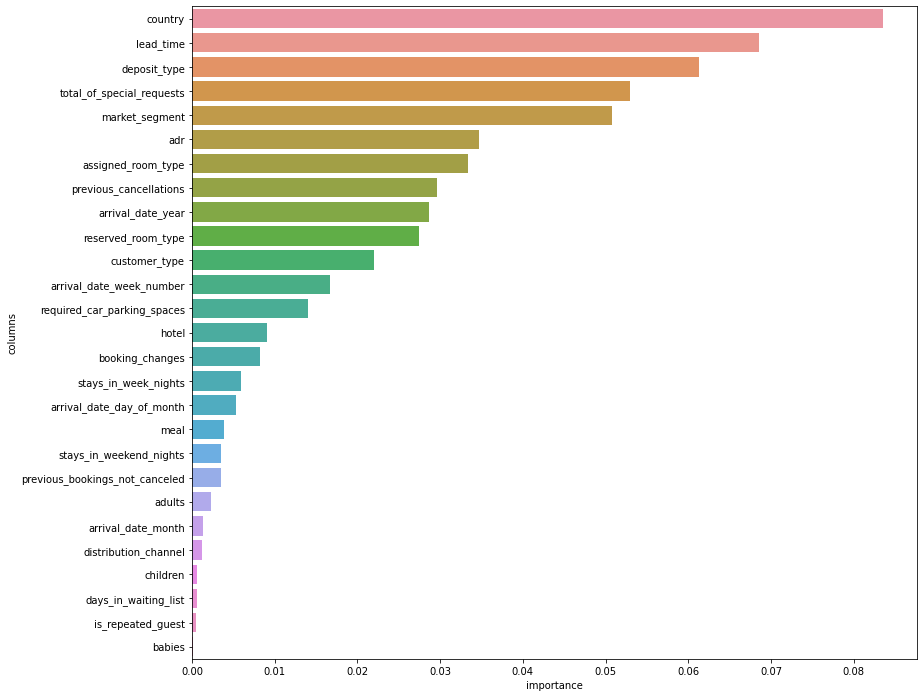

In [87]:
# We see country of origin, lead time, and deposit type are the most important variables. this is something we caught on during our EDA as well.
plt.subplots(1,figsize=(13,12))
sns.barplot(x="importance",y="columns",data=df)
plt.show()

## 1.8 Evaluating Model performance on Test set

In [88]:
y_pred=pipe.predict(X_test)

In [89]:
# We choose weighted fscore since we have imbalanced classification data.
print("Weighted f1 score is:",f1_score(y_test, y_pred, average='weighted'))

Weighted f1 score is: 0.8866644686340783


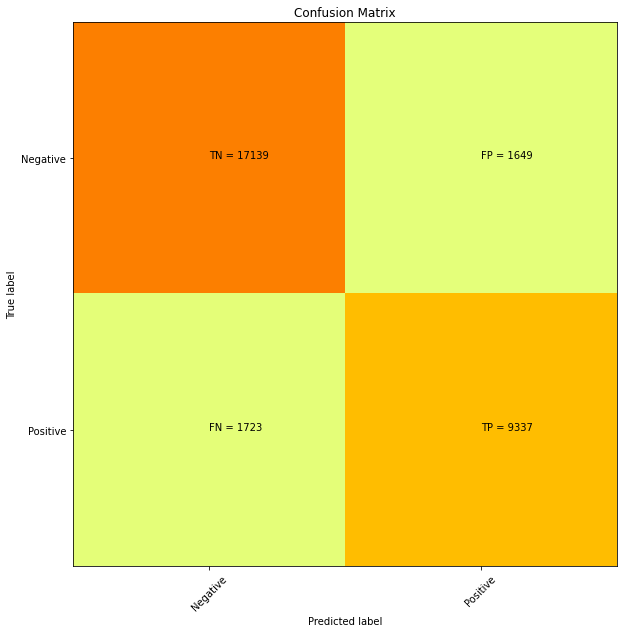

In [ ]:
# The confusion matrix helps us visualise the precision and recall. Its important for us that we are able to identify users who are cancelling correctly.
# We are able to predict users who cancelled (TP) 85% of the times. Thats good accuracy
confusio_matrix(y_test, y_pred)

In [ ]:
# We are able to precisely predict the 0s and 1s with 91% and 85% accuracy.

print(classification_report(y_test, y_pred, target_names=['0','1']))

              precision    recall  f1-score   support

           0       0.91      0.91      0.91     18788
           1       0.85      0.84      0.85     11060

    accuracy                           0.89     29848
   macro avg       0.88      0.88      0.88     29848
weighted avg       0.89      0.89      0.89     29848



## 1.9 Conclusion

### 1. Regularised models and trees do not get impacted by outliers, hence the models show good results despite some outliers in the data

### 2. After gridSearch and hyperparameter tunnig we found XGBoost is the best model in indentifying whether a user cancelled his booking or not.

### 3. XgBoost worked the best because it adds regularization to the loss function to reduce model complexity and increase generalisation. 

### 3. We adjusted the model weights due to class imbalance in target variable. Our final model has a overall balanced accuracy score 88.69%. 

### 4. It classifies 85% of the users who cancelled correctly and 91% who did not cancel correctly.



## 1.10 How can this model be used?

### 1. This model will be helpful in highlighting the bookings which have high propensity of cancellation. 

### 2. The hotels can use this model to impose high cancellation fee on bookings which the model has detected as likely to be cancelled. This will discourage the customer from cancelling or the booking will be done by a user who is less likely to cancel

## 1.11 Next steps for the model 

### 1. The model currently uses a snippet of data on a fixed timeframe (from July 2015 to August 2017). With time the needs of the customers can evolve, and hence productionising this code on dynamic datasets will help 
### 2. Its normal for users to change some atttributes of their booking at the last moment, which can influence the model results. Its important that the model is scaled and productionised so that the model stays updated

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=aa268a46-3542-4a0a-85f2-14c43bc3e6e2' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>